## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [10]:
using PyCall
using DataFrames
using Statistics

using Clustering
@pyimport scipy.spatial as sp

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)

In [11]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable test.vot read
## Filtering done ...
## Stars selected: 12531
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]


(GaiaClustering.Df(12531, [351.969 145.368 … 311.371 301.486; -10.9538 -4.46739 … 1.59019 1.33356; … ; 0.0727531 0.10941 … 0.0833555 0.134977; 0.0624644 0.119099 … 0.0617922 0.0464716], [277.32 277.342 … 279.395 279.356; -33.2627 -33.2783 … -34.812 -34.8646; … ; 15.3938 16.2834 … 15.68 17.1638; 16.7528 18.5798 … 17.1387 18.9873], [0.0347643 0.0777114 … 0.0538083 0.208771; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037])

In [12]:
function _clusters(data , epsilon, leaf , minneigh, mincluster)
    eps = epsilon
    leafsize = leaf
    min_neighbors = minneigh
    min_cluster_size = mincluster

    res = dbscan(data , eps , leafsize = leaf, min_neighbors = minneigh, min_cluster_size=mincluster)
    
    label = Vector{Vector{Int}}()
    
    for cl in res
        indx = cl.core_indices
        append!(indx, cl.boundary_indices) 
        push!(label,indx)
    end
    return(label)
end

## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 2.7
min_nei = 5
min_cl = 11

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, min_nei, min_cl)
println("### done ...")



println("## Computing metric ...")
# println(labels)
println("spatial2d")
q2d = metric(dfcart, labels, "spatial2d" , 2.0 , 20.0, 20 )
#println(q2d)
println("spatial3d")
q3d = metric(dfcart, labels, "spatial3d" , 5.0 , 20.0, 20 )
#println(q3d)
println("velocity")
qv = metric(dfcart, labels, "velocity" , 3.0 , 30.0, 20 )
#println(qv)
println("HRD")
qp, qa = metric(dfcart, labels, "HRD" )
#println(qp)
#println(qa)

indx = labels[1]
npts = []
nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
    push!(npts, length(ilab))
end



## Starting Clustering ...
ϵ : 2.7
## dbscan..
### done ...
## Computing metric ...
spatial2d
spatial3d
velocity
HRD
Label:1 - :120
Label:2 - :20
Label:3 - :25
Label:4 - :19


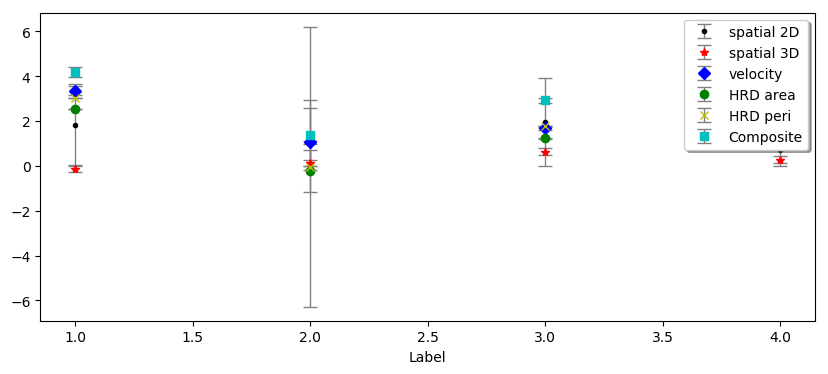

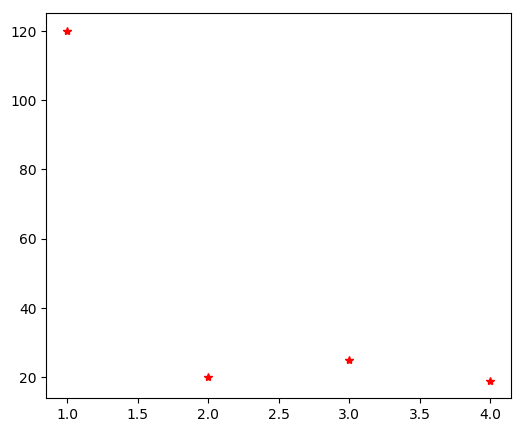

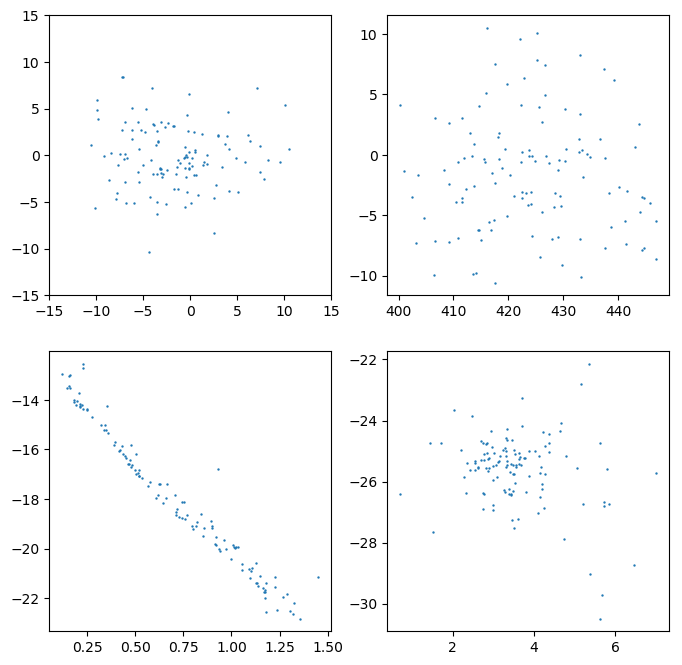

In [13]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 3.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.figure(figsize=(6.0,5.0))
plt.plot(xlabel, npts,"*r")
plt.show()


plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-15,15] , ylim = [-15,15])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()